# Add metadata to aligned sequences

I am currently using nextstrain pipelines to generated a filtered and subsampled dataset. But I need to add back in the metadata now

In [6]:
import Bio 
from Bio import SeqIO
import json
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
# read in the current date 
from datetime import date
today = date.today()
current_date = str(today.strftime("%Y-%m-%d"))

In [3]:
### notes: if I end up running this again, I should probably change these values to the middle of the month, not day 1

In [4]:
def convert_calendar_date_to_decimal_date(date_string):
    
    """if only the year is available, then set to the first of the year. if only month, set to first day of month"""
    if len(date_string) == 4: 
        date_to_query = date_string + "-01-15"
    elif len(date_string) == 7:
        date_to_query = date_string + "-01"
    else:
        date_to_query = date_string

    # call in R to convert collection date to decimal date and store as a new variable
    %R require(lubridate); library(lubridate)
    %R -i date_to_query
    %R dateR <- ymd(date_to_query)
    %R dec_date = decimal_date(dateR)
    %R -o dec_date
    decimal_date = str(dec_date).replace("[1] ","").strip()
        
    decimal_date = float(decimal_date)
    
    return(decimal_date)

In [5]:
def read_metadata_file(metadata_file):
    output_dict = {}
    with open(metadata_file, "r") as infile: 
        for line in infile: 
            if "originating_lab" not in line:
                strain = line.split("\t")[0]
                accession = line.split("\t")[2]
                date = line.split("\t")[3]
                region = line.split("\t")[4]
                country = line.split("\t")[5]
                host_group = line.split("\t")[8]
                host_species = line.split("\t")[12]
                domestic_wild = line.split("\t")[13]
                annotation_method = line.split("\t")[14]
                genbank_id = line.split("\t")[15]
                
                
                decimal_date = convert_calendar_date_to_decimal_date(date.replace("-XX",""))
                
                output_dict[strain] = {"accession":accession,"date":date, "region":region, "country":country,
                                       "domestic_wild":domestic_wild,"host_group":host_group, "host_species":host_species,
                                       "annotation_method":annotation_method,"genbank_id":genbank_id, 
                                      "decimal_date":decimal_date}
    return(output_dict)

In [21]:
"""read in the json file with the data on furin cleavage site"""

def read_in_cleavage_site_annotations(furin_cleavage_annotation_json):
    with open(furin_cleavage_annotation_json) as json_file:
        furin_annotations_dict = json.load(json_file)['nodes']
    return(furin_annotations_dict)

In [22]:
"""read in the json file with the data on furin cleavage site"""

def read_in_cleavage_site_sequences(furin_cleavage_seq_json):
    with open(furin_cleavage_seq_json) as json_file:
        furin_seq_dict = json.load(json_file)['nodes']
    return(furin_seq_dict)

In [17]:
"""I would like to try running these analyses with only GsGd lineages H5 viruses. The non-GsGd lineages are
incredibly diverse and also appear to be sampled differently. To see if this is causing issues with my analyses
I would like to remove them. This will allow me to keep a list of sequences that I want to not be included in the 
final alignment if I so desire."""

def read_in_unwanted_sequences(sequences_to_exclude_list):

    seqs_to_exclude = []
    with open(sequences_to_exclude_list, "r") as infile: 
        for line in infile:
            strain_name = line.split("|")[0]
            accession = line.split("|")[6]
            seqs_to_exclude.append(strain_name)
    
    seqs_to_exclude = list(set(seqs_to_exclude))
    return(seqs_to_exclude)

In [37]:
def write_new_alignment_files(input_alignment, output_filename, metadata_dict, seqs_to_exclude, furin_annotation_dict, furin_seq_dict):
    
    with open(output_filename, "w") as outfile: 
        outfile.write("")
        
    for seq in SeqIO.parse(input_alignment, "fasta"):
        sequence = str(seq.seq)
        strain_name = seq.description
        
        # don't write out sequences we want to exclude, like non-GsGd lineage H5 virusess
        if strain_name not in seqs_to_exclude:
            
            metadata = metadata_dict[strain_name]
            host_group = metadata_dict[strain_name]['host_group'].replace(" ","_")
            region = metadata_dict[strain_name]['region'].replace(" ","_")
            country = metadata_dict[strain_name]['country'].replace(" ","_")
            genbank_id = metadata_dict[strain_name]['genbank_id'].replace(" ","_")
            accession = metadata_dict[strain_name]['accession'].replace(" ","_")
            host_species = metadata_dict[strain_name]['host_species'].replace(" ","_")
            domestic_wild = metadata_dict[strain_name]['domestic_wild'].replace(" ","_")
            date = metadata_dict[strain_name]['date']
            decimal_date = metadata_dict[strain_name]['decimal_date']
            
            # look up furin cleavage site info
            furin_site_annotation = furin_annotation_dict[strain_name]['furin_cleavage_motif']
            furin_site_sequence = furin_seq_dict[strain_name]['cleavage_site_sequence']

            new_header = "|".join([strain_name, str(decimal_date), date, host_group, region, country, genbank_id, accession, furin_site_annotation, furin_site_sequence, host_species, domestic_wild])
 
            with open(output_filename, "a") as outfile: 
                outfile.write(">" + new_header + "\n" + sequence + "\n")
                
        else: 
            print(strain_name, "has been excluded")

In [19]:
metadata_file = "/Users/lmoncla/src/h5n1-host-classification/metadata-with-annotations/metadata_h5n1_ha-full-genomes-only-2020-10-07.txt"
metadata_dict = read_metadata_file(metadata_file)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: lubridate

  warnings.warn(x, RRuntimeWarning)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘lubridate’


  warnings.warn(x, RRuntimeWarning)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following object is masked from ‘package:base’:

    date


  warnings.warn(x, RRuntimeWarning)


In [20]:
# remove the non-GsGd lineage H5 viruses
sequences_to_exclude_list = "../beast/non-GsGd-strains-2020-01-12.txt"
seqs_to_exclude = read_in_unwanted_sequences(sequences_to_exclude_list)
print(len(seqs_to_exclude))

31


In [50]:
# read in furin cleavage site annotations 
furin_annotations_file = "../avian-flu-k99/subsample-3-2022-01-06/results/cleavage-site_h5n1_ha.json"
furin_seq_file = "../avian-flu-k99/subsample-3-2022-01-06/results/cleavage-site-sequences_h5n1_ha.json"

furin_annotations_dict = read_in_cleavage_site_annotations(furin_annotations_file)
furin_sequences_dict = read_in_cleavage_site_sequences(furin_seq_file)

In [51]:
input_alignments_directory = "../avian-flu-k99/"
output_alignments_directory = "../beast/alignments/"

In [52]:
input_alignment = input_alignments_directory + "subsample-3-2022-01-06/results/aligned_h5n1_ha.fasta"
output_filename = output_alignments_directory + "aligned_h5n1_ha-subsample-3-with-annotations-" +current_date+".fasta"

In [53]:
write_new_alignment_files(input_alignment, output_filename, metadata_dict, seqs_to_exclude, furin_annotations_dict,furin_sequences_dict)

A/duck/France/160678/2016 has been excluded
A/duck/France/160927/2016 has been excluded
A/guineafowl/France/160009/2016 has been excluded
A/chicken/France/150169a/2015 has been excluded
A/mallard/France/150018/2015 has been excluded
A/chicken/Scotland/532/2016 has been excluded
A/teal/Germany/Wv632/2005 has been excluded
A/duck/France/080036/2008 has been excluded
A/wildduck/Korea/SNU50-5/2009 has been excluded
A/mallard/Hokkaido/24/2009 has been excluded
A/duck/France/05066b/2005 has been excluded
A/ruddyturnstone/DE/509531/2007 has been excluded
A/ruddyturnstone/NewJersey/AI07-699/2007 has been excluded
A/ruddyturnstone/NewJersey/AI07-69/2007 has been excluded
A/muteswan/MI/451072-2/2006 has been excluded
A/wildduck/Ohio/623/2004 has been excluded
A/northernshoveler/Mississippi/11OS5805/2011 has been excluded
A/Americanblackduck/Alberta/118/2016 has been excluded
A/chicken/NewJersey/15-002659-2/2015 has been excluded
A/gadwallduck/Tennessee/17OS0341/2017 has been excluded
A/bluewinge

In [32]:
 """I would like to try running these analyses with only GsGd lineages H5 viruses. The non-GsGd lineages are
incredibly diverse and also appear to be sampled differently. To see if this is causing issues with my analyses
I would like to remove them. This will allow me to keep a list of sequences that I want to not be included in the 
final alignment if I so desire."""

def remove_unwanted_sequences_afterwards(sequences_to_exclude_list, alignment, output_filename):

    seqs_to_exclude = []
    with open(sequences_to_exclude_list, "r") as infile: 
        for line in infile:
            seqs_to_exclude.append(line.strip())
    
    seqs_to_exclude = list(set(seqs_to_exclude))
    
    
    for seq in SeqIO.parse(alignment, "fasta"):
        if seq.description in seqs_to_exclude: 
            print("removing ", seq.description)
        else: 
            with open(output_filename, "a") as outfile: 
                outfile.write(">" + seq.description + "\n" + str(seq.seq) + "\n")

In [36]:
alignment = alignments_directory + "aligned_ha-with-annotations-2020-10-26-1-per-month.fasta"
output_filename = alignments_directory + "aligned_h5n1_ha-3deme-1-per-region-month-host-with-annotations"+current_date+".fasta"

remove_unwanted_sequences_afterwards(sequences_to_exclude_list, alignment, output_filename)

removing  A/teal/Germany/WV632/2005|2005.0|2005-XX-XX|Avian|Europe|Germany|CY061885|CY061885|teal|wild
removing  A/teal/Germany/Wv632/2005|2005.899|2005-11-25|Avian|Europe|Germany|CY061885|EPI254685|teal|wild
removing  A/duck/France/080036/2008|2008.0|2008-01-XX|Avian|Europe|France|CY046182|EPI229989|duck|domestic
removing  A/mallard/France/150018/2015|2015.134|2015-02-19|Avian|Europe|France||EPI1156382|mallard|wild
removing  A/chicken/Scotland/532/2016|2016.022|2016-01-09|Avian|Europe|United_Kingdom||EPI687187|chicken|domestic
removing  A/duck/France/160678/2016|2016.536|2016-07-15|Avian|Europe|France||EPI1153417|duck|domestic
removing  A/duck/France/160927/2016|2017.551|2017-07-21|Avian|Europe|France||EPI1153409|duck|domestic
removing  A/guineafowl/France/160009/2016|2015.992|2015-12-29|Avian|Europe|France||EPI1153441|guinea_fowl|domestic
removing  A/chicken/France/150169a/2015|2015.882|2015-11-19|Avian|Europe|France|KU310447|EPI839728|chicken|domestic
removing  A/wildduck/Korea/SNU5

## How many complete dates did we get?

In [11]:
def return_date_resolution(date):
    date = date.replace("-XX","")
    
    if len(date) == 4:
        date_resolution = "year"
    elif len(date) == 7:
        date_resolution = "month"
    elif len(date) == 10:
        date_resolution = "day"
    else:
        print("what's up with this date ", date)
    
    return(date_resolution)

In [12]:
def return_dates(input_file):
    years = {}
    
    for seq in SeqIO.parse(input_file, "fasta"):
        sequence = str(seq.seq)
        strain_name = seq.description.split("|")[0]
        
        metadata = metadata_dict[strain_name]
        host_group = metadata_dict[strain_name]['host_group'].replace(" ","_")
        region = metadata_dict[strain_name]['region'].replace(" ","_")
        country = metadata_dict[strain_name]['country'].replace(" ","_")
        domestic_wild = metadata_dict[strain_name]['domestic_wild'].replace(" ","_")
        date = metadata_dict[strain_name]['date']

        year = int(date[0:4])
        date_resolution = return_date_resolution(date)
        
        if year not in years: 
            years[year] = {"total": 1, date_resolution: 1}
        else:
            years[year]["total"] += 1
            
            if date_resolution not in years[year]:
                years[year][date_resolution] = 1
            else:
                years[year][date_resolution] += 1
            
    return(years)

In [13]:
input_file = "/Users/lmoncla/src/h5n1-host-classification/beast/alignments/aligned_ha-with-annotations-2020-10-26.fasta"

In [31]:
dates = return_dates(input_file)

In [32]:
import pandas as pd
dates_df = pd.DataFrame.from_dict(dates, orient="index")
dates_df.reset_index(inplace=True)
dates_df = dates_df.fillna(0)
dates_df

,index,total,year,day,month
0,1996,1,1.0,0.0,0.0
1,1997,15,15.0,0.0,0.0
2,1998,1,1.0,0.0,0.0
3,1999,1,1.0,0.0,0.0
4,2000,8,8.0,0.0,0.0
5,2001,13,13.0,0.0,0.0
6,2002,15,15.0,0.0,0.0
7,2003,34,28.0,6.0,0.0
8,2004,60,51.0,9.0,0.0
9,2005,80,61.0,19.0,0.0


In [23]:
dates_df_melt = dates_df.melt(id_vars=['index','total'])
dates_df_melt.head()

,index,total,variable,value
0,1996,1,year,1.0
1,1997,15,year,15.0
2,1998,1,year,1.0
3,1999,1,year,1.0
4,2000,9,year,9.0


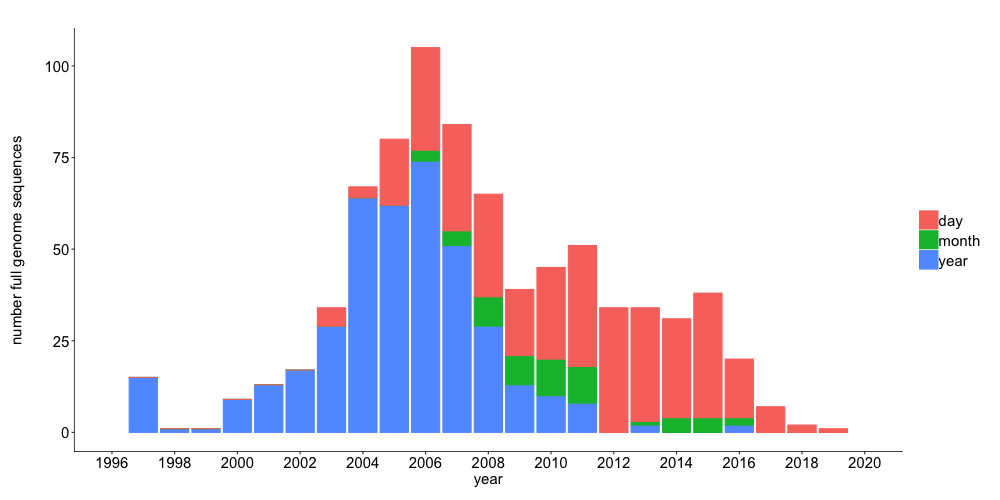

In [25]:
%%R -w 1000 -h 500 -u px -i dates_df_melt  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

dates_df_melt$index = as.numeric(dates_df_melt$index)

p <- ggplot(data=dates_df_melt, aes(x=index, y=value, color=variable, fill=variable)) + 
    geom_col()+
    #geom_vline(xintercept=vlines1, size=0.8, linetype='dashed', color = '#808080')+
    labs(x="year",y="number full genome sequences")+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    #scale_colour_manual(values=c("#4C9C86","#271B9C"), guide=FALSE)+
    #scale_y_continuous(limits=c(0,275), breaks=seq(0,275,25))+
    scale_x_continuous(limits=c(1996,2020), breaks=seq(0,2020,2))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=15))+
    theme(axis.title.y=element_text(size=15, vjust=8))+
    theme(axis.title.x=element_text(size=15))+
    theme(axis.text=element_text(size=15, colour="black"))+
    theme(legend.text=element_text(size=15))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1.0,0.5,0.5,1.0),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

#ggsave("available-seqs-per-year-date-resolution-2020-10-26.pdf", p, width = 12, height = 5, path=output_directory)
p